Run on NERSC

In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
def binned_stats(x, y, bins):
    from scipy import stats
    nmad = lambda x: 1.4826*np.median(np.abs(x-np.median(x)))
    bin_center, bin_median, bin_scatter = np.zeros((3, len(bins)-1))
    for index in range(len(bins)-1):
        mask = (x>bins[index]) & (x<bins[index+1])
        bin_center[index] = np.median(x[mask])
        if np.sum(mask)>0:
            bin_median[index] = np.median(y[mask])
            bin_scatter[index] = nmad(y[mask])
        else:
            bin_median[index], bin_scatter[index] = np.nan, np.nan
    return bin_center, bin_median, bin_scatter

def plot_cutout(img, pixscale, vmin=-1, vmax=1, unit='arcsec'):
    if unit=='arcsec':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])
    elif unit=='arcmin':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/60.
    elif unit=='deg':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/3600.
    else:
        raise ValueError('unrecognized unit')
    fig, ax = plt.subplots(figsize=(8, 8))
    dens = ax.imshow(img, aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    ax.axvline(0, ls='--', lw=0.5, color='grey')
    ax.axhline(0, ls='--', lw=0.5, color='grey')
    fig.colorbar(dens, fraction=0.046, pad=0.04)
    ax.grid(alpha=0.5)
    return ax

def plot_cutout_sizebysize(img1, img2, title1, title2, pixscale, vmin=-1, vmax=1, unit='arcsec'):
    if unit=='arcsec':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])
    elif unit=='arcmin':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/60.
    elif unit=='deg':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/3600.
    else:
        raise ValueError('unrecognized unit')
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].imshow(img1, aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    axes[0].axvline(0, ls='--', lw=0.5, color='grey')
    axes[0].axhline(0, ls='--', lw=0.5, color='grey')
    axes[0].set_title(title1)
    axes[0].set_xlabel('RA (arcsec)')
    axes[0].set_ylabel('DEC (arcsec)')
    im = axes[1].imshow(img2, aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    axes[1].axvline(0, ls='--', lw=0.5, color='grey')
    axes[1].axhline(0, ls='--', lw=0.5, color='grey')
    axes[1].set_title(title2)
    axes[1].set_xlabel('RA (arcsec)')
    axes[1].set_ylabel('DEC (arcsec)')
    # fig.colorbar(im, fraction=0.046, pad=0.04)
    return axes

In [4]:
field = 'south'
output_name = 'decals_ngc'
band = 'g'

if (field=='north') and ((band=='g') or (band=='r')):
    pixscale_native = 0.454
else:
    pixscale_native = 0.262
# pixscale = 0.262 # pixscale for cutout queries

ls_mag_bins = [10.5, 11.75, 13.0, 14.25, 15.5]

In [5]:
profile = Table.read('../data/average_profiles_{}_{}_{}.txt'.format(field, output_name, band), format='ascii.commented_header')
indiv = Table.read('../data/individual_profiles_{}_{}_{}.fits'.format(field, output_name, band))

profile[:3]

radius_g_10.50,flux_g_10.50,flux_scatter_g_10.50,radius_g_11.75,flux_g_11.75,flux_scatter_g_11.75,radius_g_13.00,flux_g_13.00,flux_scatter_g_13.00,radius_g_14.25,flux_g_14.25,flux_scatter_g_14.25,radius_g_15.50,flux_g_15.50,flux_scatter_g_15.50
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.763854698225,146.493606681,4.68426971828,0.763854698225,146.394984918,5.07078105876,0.763854698225,146.203129126,5.7261200756,0.667971556281,149.622109429,10.4798952242,0.763854698225,100.188589577,7.67375069711
1.58287902254,146.493552908,4.65786387587,1.49362980688,146.395069282,5.0707292587,1.58287902254,145.801101095,5.95629228893,1.66735779004,25.334453553,11.8556600633,1.58287902254,9.73879333711,2.98552012469
2.51983531208,146.240729408,4.67031703525,2.57374163427,53.4068038685,27.8617300515,2.57374163427,11.9682653738,3.49869627839,2.51983531208,3.73469775432,1.16103127316,2.51983531208,1.33127066577,0.534068294516


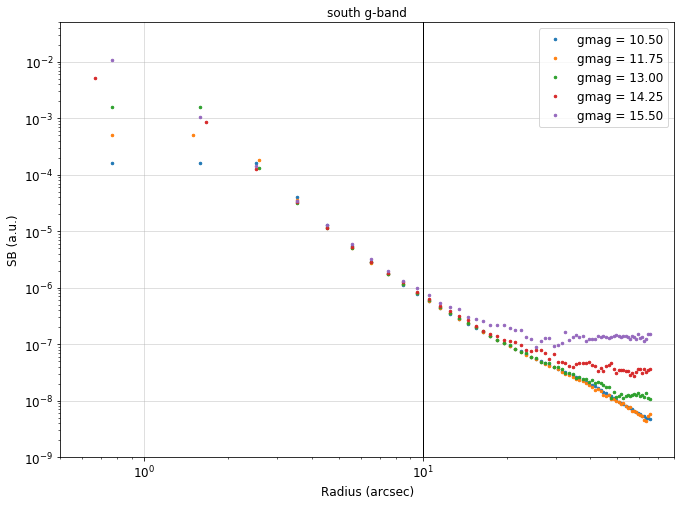

In [6]:
plt.figure(figsize=(11, 8))
for index in range(len(ls_mag_bins)):
    # normalize the flux to 22.5 magnitude stars
    norm = 10**((ls_mag_bins[index]-22.5)/2.5)
    # normalize to flux per pixel
    norm = norm * pixscale_native**2
    x = profile['radius_{}_{:.2f}'.format(band, ls_mag_bins[index])]
    y = norm * profile['flux_{}_{:.2f}'.format(band, ls_mag_bins[index])]
    plt.loglog(x, y, '.', lw=1.2, alpha=1., ms=5.,
               label='{}mag = {:.2f}'.format(band, ls_mag_bins[index]), c='C'+str(index))
plt.axvline(10, lw=1, color='k')
plt.title('{} {}-band'.format(field, band))
plt.axis([0.5, 80, 1e-9, 5e-2])
plt.grid(alpha=0.5)
plt.xlabel('Radius (arcsec)')
plt.ylabel('SB (a.u.)')
plt.legend()
plt.show()

__5th-order polynomial__

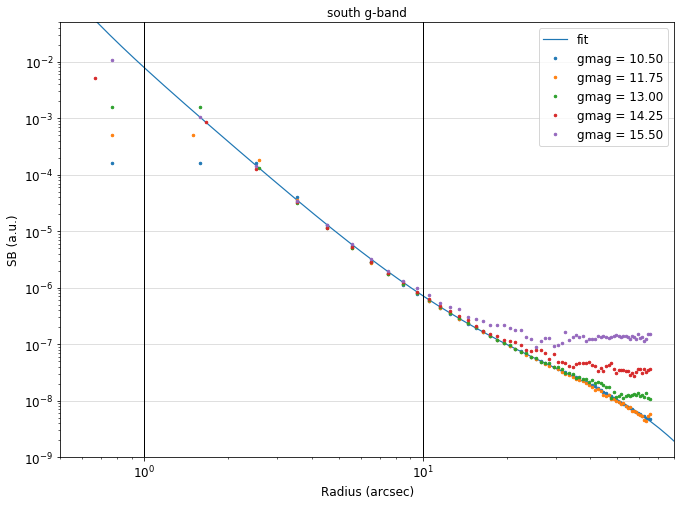

In [7]:
rmin, rsep, rmax = 1, 10, np.inf

# stitch together the profiles of two magnitude bins
index = -1
norm = 10**((ls_mag_bins[index]-22.5)/2.5) * pixscale_native**2
x = profile['radius_{}_{:.2f}'.format(band, ls_mag_bins[index])]
y = norm * profile['flux_{}_{:.2f}'.format(band, ls_mag_bins[index])]
mask = (x>rmin) & (x<rsep)
xdata = x[mask]
ydata = y[mask]

index = 0
norm = 10**((ls_mag_bins[index]-22.5)/2.5) * pixscale_native**2
x = profile['radius_{}_{:.2f}'.format(band, ls_mag_bins[index])]
y = norm * profile['flux_{}_{:.2f}'.format(band, ls_mag_bins[index])]
mask = (x>=rsep) & (x<np.inf)
xdata = np.concatenate((xdata, x[mask]))
ydata = np.concatenate((ydata, y[mask]))

##############################################################################

xlog, ylog = np.log10(xdata), np.log10(ydata)
poly = np.polyfit(xlog, ylog, deg=5)
profile_fit = np.poly1d(poly)

# xfit = np.linspace(0.1, 300, 2000)
xfit = np.logspace(-1, 2, 200)
yfit = 10**(profile_fit(np.log10(xfit)))

# plt.figure(figsize=(11, 8))
# plt.loglog(xfit, yfit, '-', lw=1.2, alpha=1., 
#            label='fit', c='C0')
# plt.loglog(xdata, ydata, '.', lw=1.2, alpha=1., ms=5.,
#            label='data', c='r')
# plt.title('{} {}-band'.format(field, band))
# plt.axis([0.5, 80, 1e-9, 5e-2])
# plt.grid(alpha=0.5)
# plt.xlabel('Radius (arcsec)')
# plt.ylabel('SB (a.u.)')
# plt.axvline(rmin, lw=1, color='k')
# plt.axvline(rsep, lw=1, color='k')
# plt.legend()
# plt.show()

# ydata_fit = 10**(profile_fit(np.log10(xdata)))
# plt.figure(figsize=(11, 8))
# plt.semilogx(xdata, (ydata_fit-ydata)/ydata, '.', lw=1.2, alpha=1., ms=5.,
#            label='data', c='r')
# plt.title('{} {}-band'.format(field, band))
# plt.axis([1, 80, -0.2, 0.2])
# plt.grid(alpha=0.5)
# plt.xlabel('Radius (arcsec)')
# plt.ylabel('Fractional residual')
# plt.axvline(rmin, lw=1, color='k')
# plt.axvline(rsep, lw=1, color='k')
# plt.legend()
# plt.show()


# plt.figure(figsize=(11, 8))
# plt.loglog(xfit, yfit, '-', lw=1.2, alpha=1., 
#            label='fit', c='C0')
# plt.loglog(xdata, ydata, '.', lw=1.2, alpha=1., ms=5.,
#            label='data', c='r')
# plt.title('{} {}-band'.format(field, band))
# # plt.axis([1, 80, .0002, 200])
# plt.grid(alpha=0.5)
# plt.xlabel('Radius (arcsec)')
# plt.ylabel('SB (a.u.)')
# plt.axvline(rmin, lw=1, color='k')
# plt.axvline(rsep, lw=1, color='k')
# plt.legend()
# plt.show()

plt.figure(figsize=(11, 8))
plt.loglog(xfit, yfit, '-', lw=1.2, alpha=1., 
           label='fit', c='C0')
for index in range(len(ls_mag_bins)):
    # normalize the flux to 22.5 magnitude stars
    norm = 10**((ls_mag_bins[index]-22.5)/2.5) * pixscale_native**2
    x = profile['radius_{}_{:.2f}'.format(band, ls_mag_bins[index])]
    y = norm * profile['flux_{}_{:.2f}'.format(band, ls_mag_bins[index])]
    plt.loglog(x, y, '.', lw=1.2, alpha=1., ms=5.,
               label='{}mag = {:.2f}'.format(band, ls_mag_bins[index]), c='C'+str(index))
plt.title('{} {}-band'.format(field, band))
plt.axis([0.5, 80, 1e-9, 5e-2])
plt.axvline(rmin, lw=1, color='k')
plt.axvline(rsep, lw=1, color='k')
plt.grid(alpha=0.5)
plt.xlabel('Radius (arcsec)')
plt.ylabel('SB (a.u.)')
plt.legend()
plt.show()

---------

In [8]:
# ls /global/project/projectdirs/cosmo/work/legacysurvey/dr9/reorg/

In [9]:
# ccd = fitsio.read('/global/project/projectdirs/cosmo/work/legacysurvey/dr9/survey-ccds-decam-dr9.fits.gz')
ccd = fitsio.read('/global/project/projectdirs/cosmo/work/legacysurvey/dr9/reorg/survey-ccds-decam-dr9-newlocs2.fits.gz')
# if field=='south':
#     ccd = fitsio.read('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/survey-ccds-decam-dr8.fits.gz')
# elif field=='north' and band=='z':
#     ccd = fitsio.read('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/survey-ccds-mosaic-dr8.fits.gz')
# elif field=='north' and (band=='g' or band=='r'):
#     ccd = fitsio.read('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/survey-ccds-90prime-dr8.fits.gz')
# else:
#     raise ValueError
ccd = Table(ccd)
print(len(ccd))

3560028


In [10]:
ccd[:3]

image_filename,image_hdu,camera,expnum,plver,procdate,plprocid,ccdname,object,propid,filter,exptime,mjd_obs,airmass,fwhm,width,height,ra_bore,dec_bore,crpix1,crpix2,crval1,crval2,cd1_1,cd1_2,cd2_1,cd2_2,yshift,ra,dec,skyrms,sig1,ccdzpt,zpt,ccdraoff,ccddecoff,ccdskycounts,ccdskysb,ccdrarms,ccddecrms,ccdphrms,ccdnastrom,ccdnphotom,ccd_cuts
bytes120,int16,bytes5,int64,bytes8,bytes19,bytes7,bytes3,bytes35,bytes10,bytes1,float32,float64,float32,float32,int16,int16,float64,float64,float32,float32,float64,float64,float32,float32,float32,float32,bool,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16
decam/CP/V4.8.2a/CP20151129/c4d_151130_081500_ooi_z_ls9.fits.fz,1,decam,497886,V4.8.2a,2019-08-15T20:19:21,955491a,S29,DES survey hex 789-278 tiling 5,2012B-0001,z,90.0,57356.3421146,1.25,3.42152,2046,4094,79.0185291667,-27.5035638889,13422.2,6306.33,79.0183543503,-27.5024703633,4.71147e-08,7.28592e-05,-7.2851e-05,4.44218e-08,False,78.670565547,-26.5982734359,0.245161,0.0256225,24.9645,24.9684,-0.0253014,-0.0104046,20.9605,20.272,0.0299294,0.0177932,0.0172867,244,260,1
decam/CP/V4.8.2a/CP20151129/c4d_151130_081500_ooi_z_ls9.fits.fz,2,decam,497886,V4.8.2a,2019-08-15T20:19:21,955491a,S31,DES survey hex 789-278 tiling 5,2012B-0001,z,90.0,57356.3421146,1.25,3.46398,2046,4094,79.0185291667,-27.5035638889,13422.2,-2212.33,79.0183543503,-27.5024703633,4.71147e-08,7.28592e-05,-7.2851e-05,4.44218e-08,False,79.3651122897,-26.5978247261,0.24981,0.0253419,24.9628,24.9684,-0.0649051,-0.0237378,20.9278,20.2737,0.06637,0.0254245,0.0209268,268,295,1
decam/CP/V4.8.2a/CP20151129/c4d_151130_081500_ooi_z_ls9.fits.fz,3,decam,497886,V4.8.2a,2019-08-15T20:19:21,955491a,S25,DES survey hex 789-278 tiling 5,2012B-0001,z,90.0,57356.3421146,1.25,3.2959,2046,4094,79.0185291667,-27.5035638889,11167.8,8436.0,79.0183543503,-27.5024703633,4.71147e-08,7.28592e-05,-7.2851e-05,4.44218e-08,False,78.4961496204,-26.7619144706,0.248258,0.0244141,24.9631,24.9684,0.0371924,0.00247204,20.9447,20.2728,0.0412779,0.0140377,0.0181454,259,279,1


In [11]:
# cp /global/project/projectdirs/cosmo/work/users/djschleg/dr9lists/dr9c.txt /global/u2/r/rongpu/temp/

In [12]:
# Load Schlegel's CCD file list
fn = '/global/project/projectdirs/cosmo/work/users/djschleg/dr9lists/dr9c.txt'
with open(fn, 'r') as f:
    lines = list(map(str.rstrip, f.readlines()))
print(len(lines))
print(lines[0])

2191
c4d_130902_061047_ooi_g_ls9.fits.fz


In [13]:
ccd['basename'] = list(map(os.path.basename, ccd['image_filename']))
mask = np.in1d(ccd['basename'], np.array(lines))
print(np.sum(mask)/len(mask))
ccd = ccd[mask]
print(len(ccd))

0.0371909996214
132401


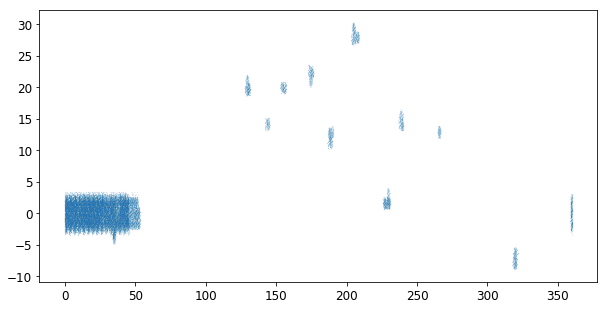

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(ccd['ra'][::5], ccd['dec'][::5], '.', ms=0.1)
plt.show()

In [38]:
# dra, ddec = 1, 1
# ra, dec = 180, 0
# ra, dec = 180, 50

######################################################################

ccd_mask = ccd['filter']==band
# ccd_mask &= (ccd['ra']>ra-dra) & (ccd['ra']<ra+dra) & (ccd['dec']>dec-ddec) & (ccd['dec']<dec+ddec)
# ccd_mask &= (ccd['dec']<33) & (ccd['dec']>-30) & (ccd['ra']>100) & (ccd['ra']<300)
# ccd_mask &= ccd['ra']<100
print(np.sum(ccd_mask))

idx = np.where(ccd_mask)[0]
nplot = 20
if len(idx)>nplot:
    np.random.seed(1)
    idx = np.random.choice(idx, size=nplot, replace=False)
    
idx = idx[np.argsort(ccd['expnum'][idx])]

44512


229702 N17 g; FWHM = 1.23


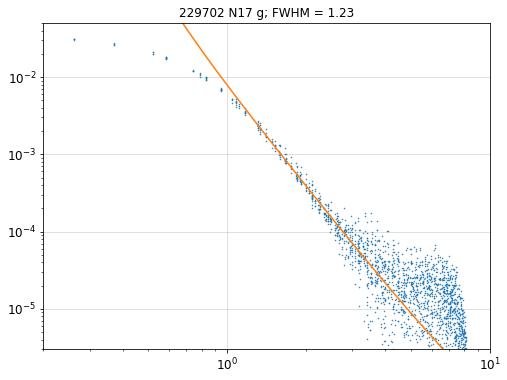

------------------------------------------------------------
238939 N17 g; FWHM = 1.40


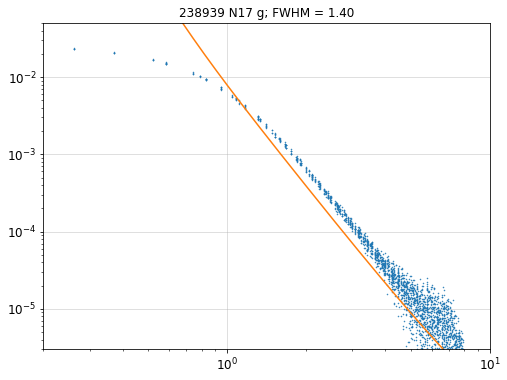

------------------------------------------------------------
240572 N14 g; FWHM = 1.22


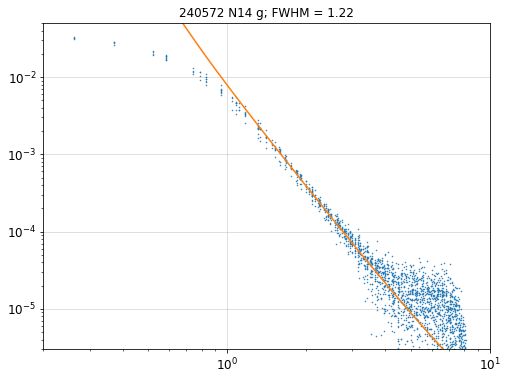

------------------------------------------------------------
241184 N28 g; FWHM = 1.20


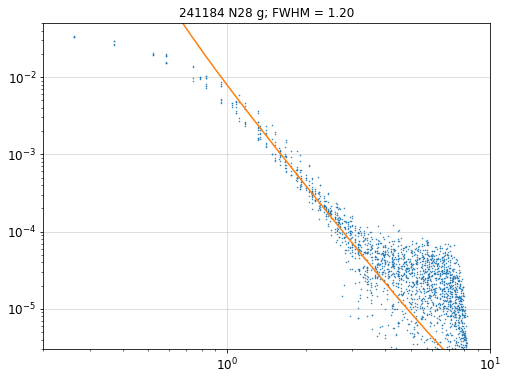

------------------------------------------------------------
247189 N10 g; FWHM = 1.66


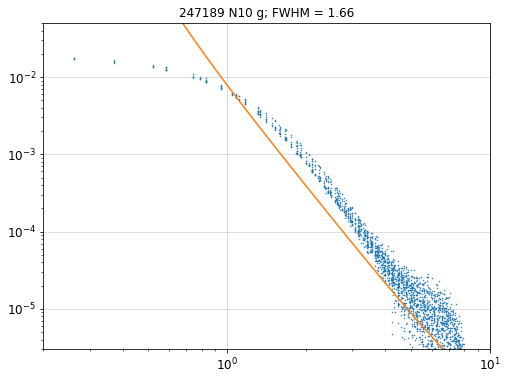

------------------------------------------------------------
257236 S14 g; FWHM = 1.24


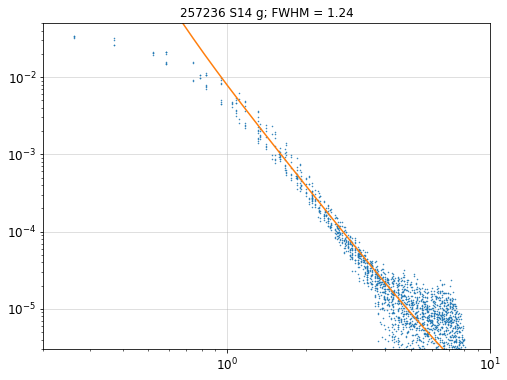

------------------------------------------------------------
268794 S17 g; FWHM = 1.02


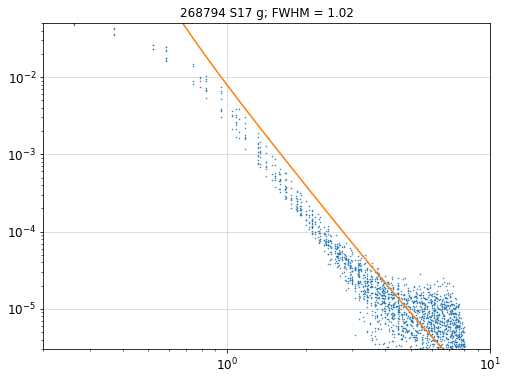

------------------------------------------------------------
511513 S21 g; FWHM = 1.17


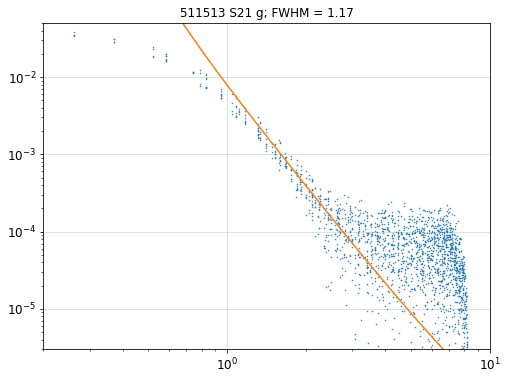

------------------------------------------------------------
579474 S24 g; FWHM = 1.29


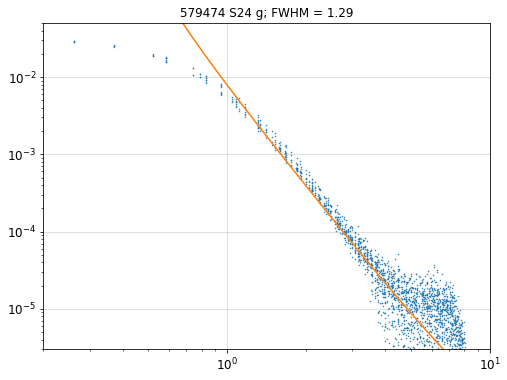

------------------------------------------------------------
585245 N3 g; FWHM = 1.47


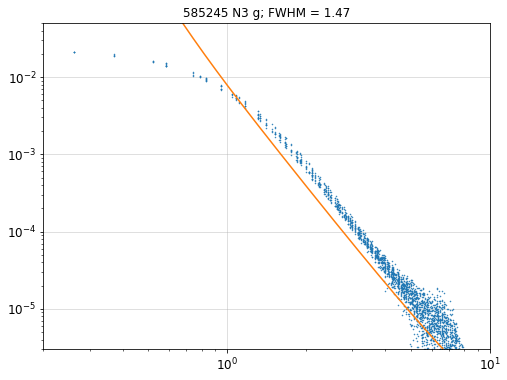

------------------------------------------------------------
586658 N23 g; FWHM = 1.27


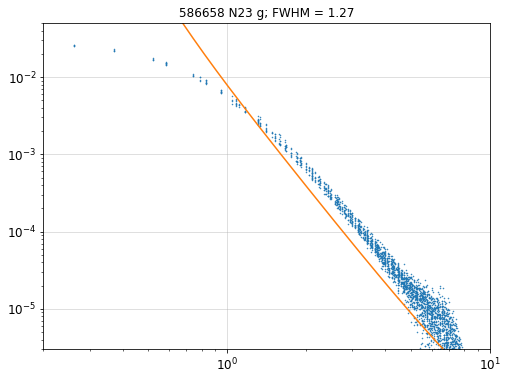

------------------------------------------------------------
593758 S5 g; FWHM = 1.12


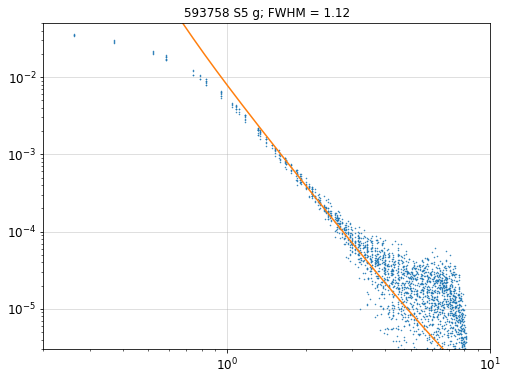

------------------------------------------------------------
596118 S4 g; FWHM = 1.12


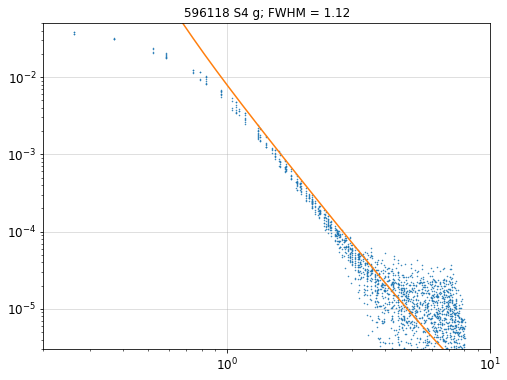

------------------------------------------------------------
659873 N28 g; FWHM = 1.33


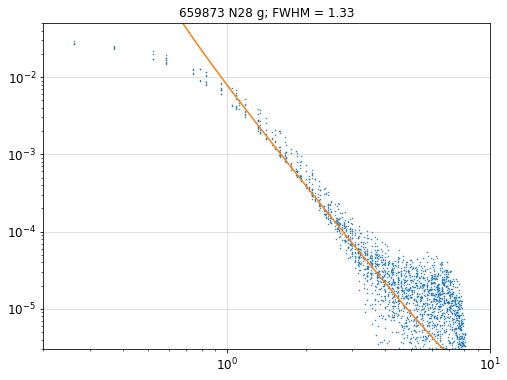

------------------------------------------------------------
670256 N22 g; FWHM = 1.08


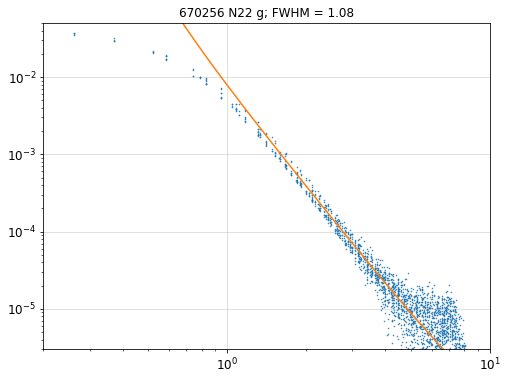

------------------------------------------------------------
672421 S23 g; FWHM = 1.07


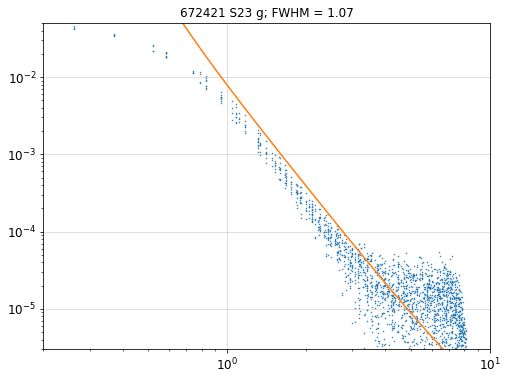

------------------------------------------------------------
672815 S4 g; FWHM = 1.26


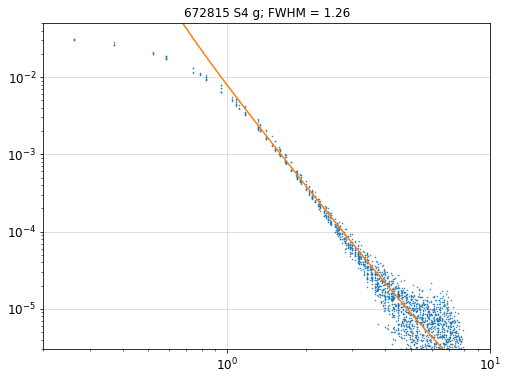

------------------------------------------------------------
680886 N20 g; FWHM = 1.11


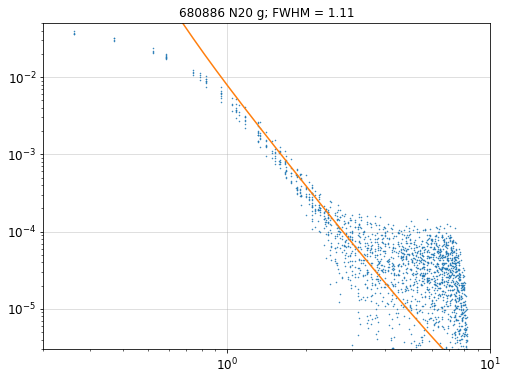

------------------------------------------------------------
692086 N23 g; FWHM = 0.91


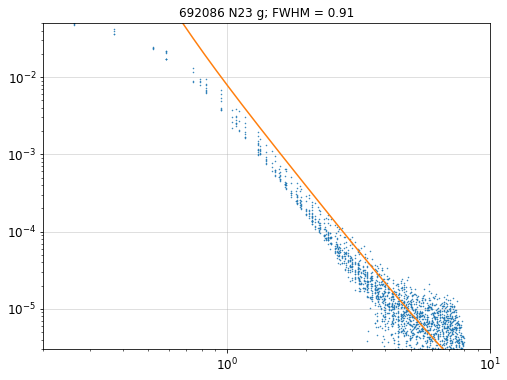

------------------------------------------------------------
696601 N5 g; FWHM = 1.19


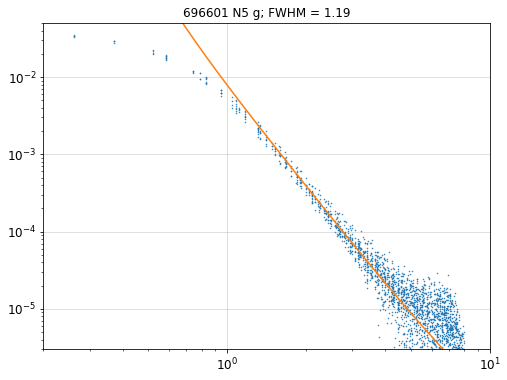

In [20]:
for index, ccd_index in enumerate(idx):

    if (index!=0) and (ccd['expnum'][ccd_index]!=ccd['expnum'][idx[index-1]]):
        print('------------------------------------------------------------')
    
    expnum = ccd['expnum'][ccd_index]
    ccdname = ccd['ccdname'][ccd_index]
    
    print('{} {} {}; FWHM = {:.2f}'.format(expnum, ccdname, ccd['filter'][ccd_index], pixscale_native*ccd['fwhm'][ccd_index]))

    expnum_str = str(expnum)

    fn = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/calib/decam/psfex-merged/{}/decam-{}.fits'.format((5-len(expnum_str[:3]))*'0'+expnum_str[:3], (8-len(expnum_str))*'0'+expnum_str)
    
    hdu = fits.open(fn)
    data = hdu[1].data
    # print(data['psf_mask'].shape)

    which_ccd = np.where(data['ccdname']==ccdname)[0][0]
    psf = data['psf_mask'][which_ccd]
    # print(psf.shape)

    psf0 = psf[0]
    # normalize to a 22.5 magnitude star
    # print(np.sum(psf0))
    psf0 = psf0/np.sum(psf0)

    grid = pixscale_native * np.linspace(-0.5*(psf0.shape[0]-1), 0.5*(psf0.shape[0]-1), psf0.shape[0])
    xx, yy = np.meshgrid(grid, grid)
    radius_grid = np.sqrt(xx**2 + yy**2)
    radius = radius_grid.flatten()

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        img_fit = 10**(profile_fit(np.log10(radius_grid)))
        img_fit[~np.isfinite(img_fit)] = 0

    x = np.logspace(-1, 10, 1000)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.figure(figsize=(8, 6))
        plt.loglog(radius, (psf0).flatten(), '.', ms=1.)
        plt.loglog(x, 10**(profile_fit(np.log10(x))), '-', ms=1.)
        plt.axis([0.2, 10, 3e-6, 0.05])
        plt.grid(alpha=0.5)
        plt.title('{} {} {}; FWHM = {:.2f}'.format(expnum, ccdname, ccd['filter'][ccd_index], pixscale_native*ccd['fwhm'][ccd_index]))
        plt.show()

------------------------------------------------------------
229702 N17 g; FWHM = 1.23


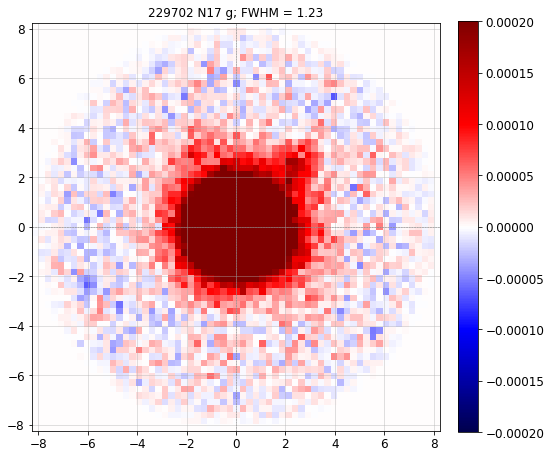

------------------------------------------------------------
238939 N17 g; FWHM = 1.40


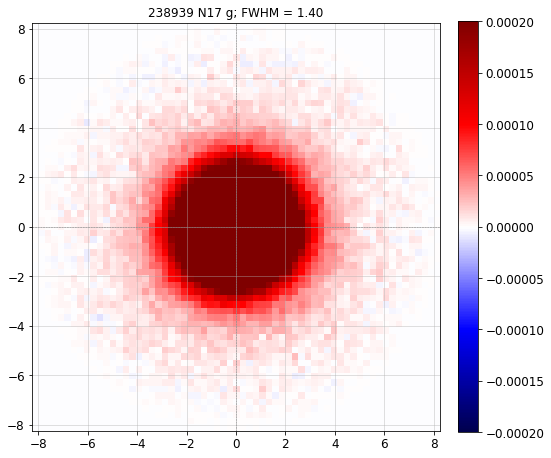

------------------------------------------------------------
240572 N14 g; FWHM = 1.22


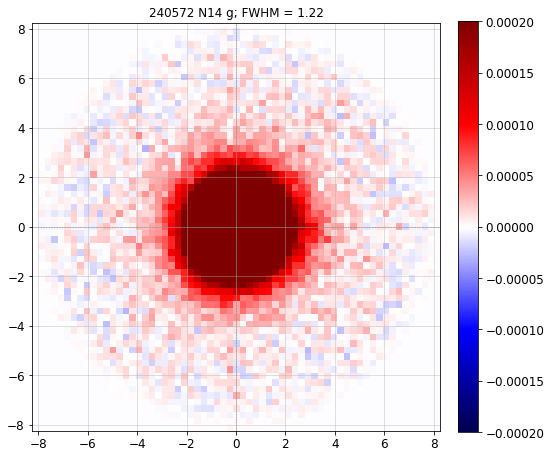

------------------------------------------------------------
241184 N28 g; FWHM = 1.20


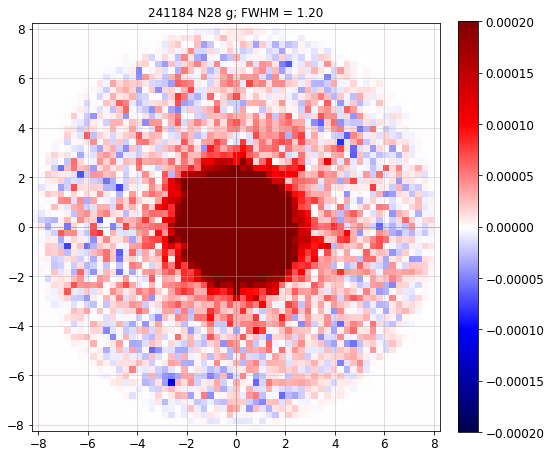

------------------------------------------------------------
247189 N10 g; FWHM = 1.66


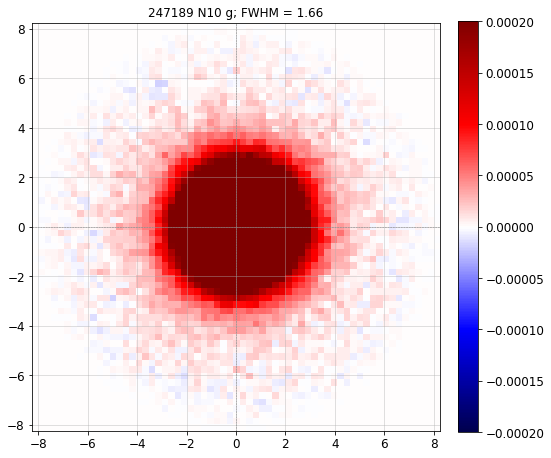

------------------------------------------------------------
257236 S14 g; FWHM = 1.24


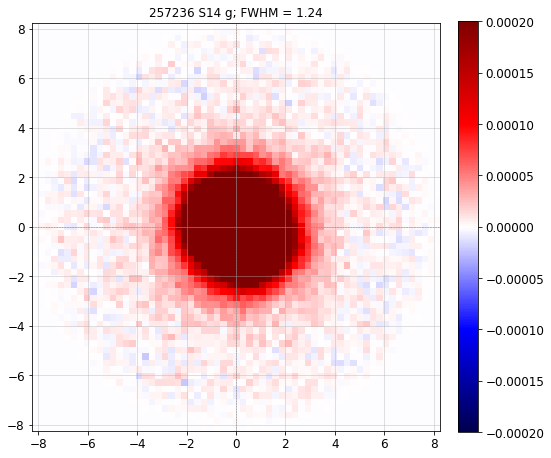

------------------------------------------------------------
268794 S17 g; FWHM = 1.02


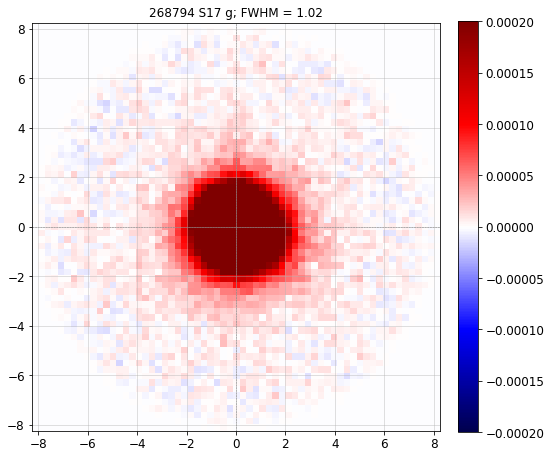

------------------------------------------------------------
511513 S21 g; FWHM = 1.17


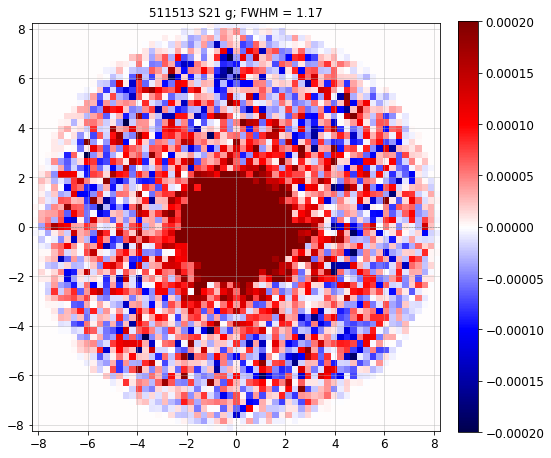

------------------------------------------------------------
579474 S24 g; FWHM = 1.29


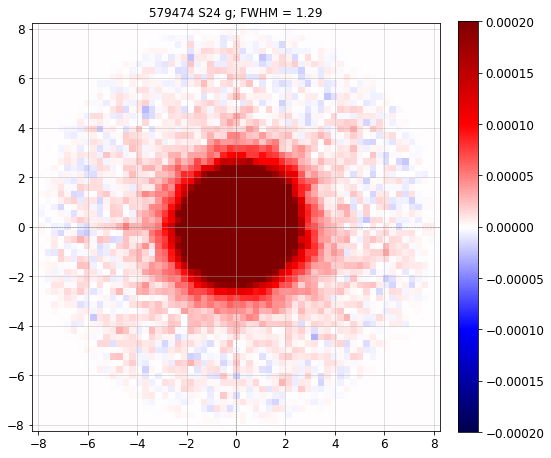

------------------------------------------------------------
585245 N3 g; FWHM = 1.47


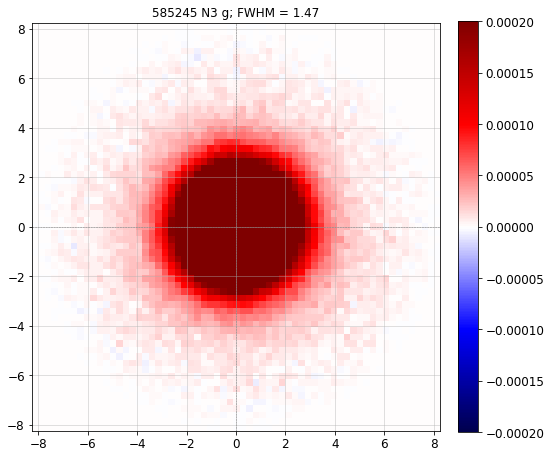

------------------------------------------------------------
586658 N23 g; FWHM = 1.27


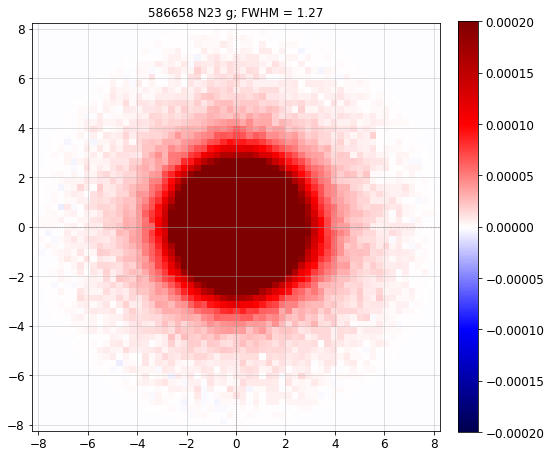

------------------------------------------------------------
593758 S5 g; FWHM = 1.12


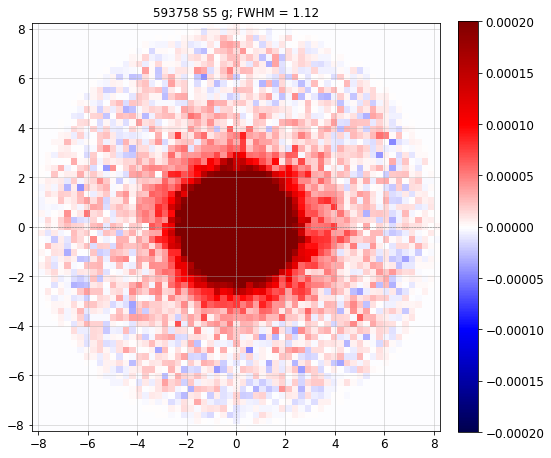

------------------------------------------------------------
596118 S4 g; FWHM = 1.12


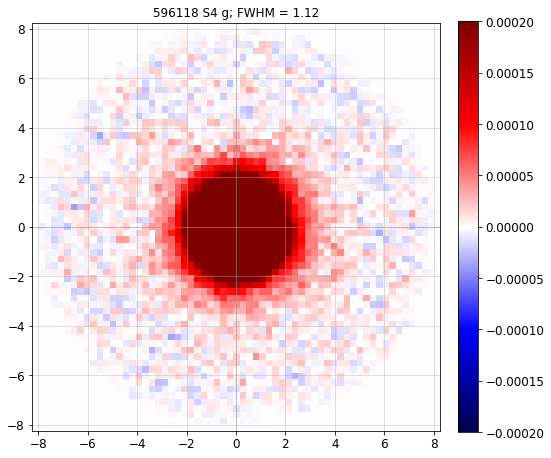

------------------------------------------------------------
659873 N28 g; FWHM = 1.33


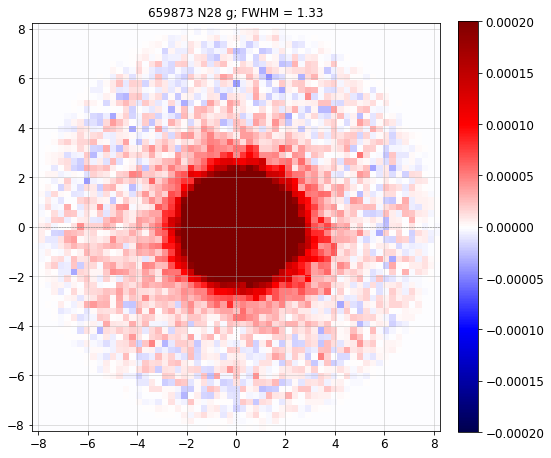

------------------------------------------------------------
670256 N22 g; FWHM = 1.08


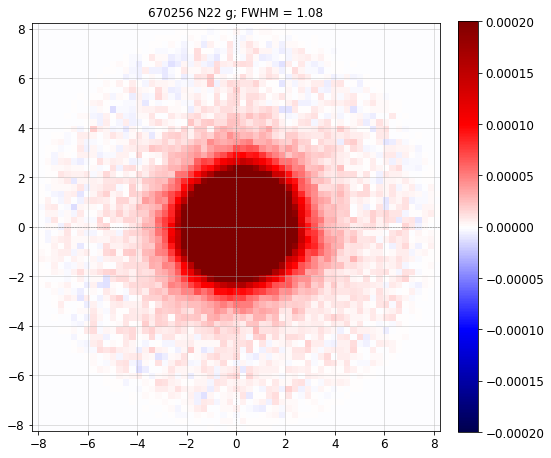

------------------------------------------------------------
672421 S23 g; FWHM = 1.07


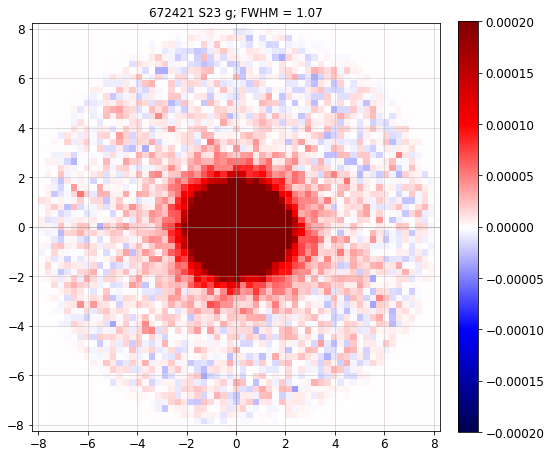

------------------------------------------------------------
672815 S4 g; FWHM = 1.26


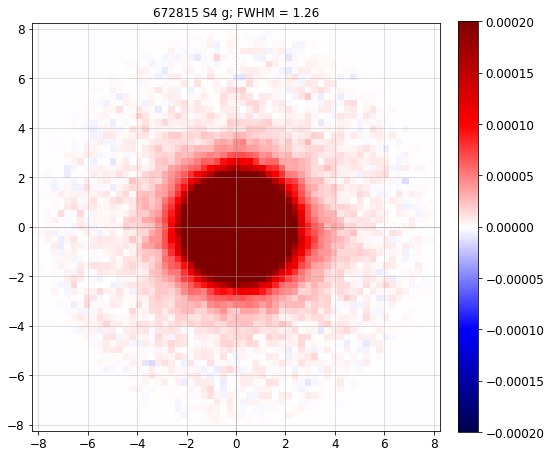

------------------------------------------------------------
680886 N20 g; FWHM = 1.11


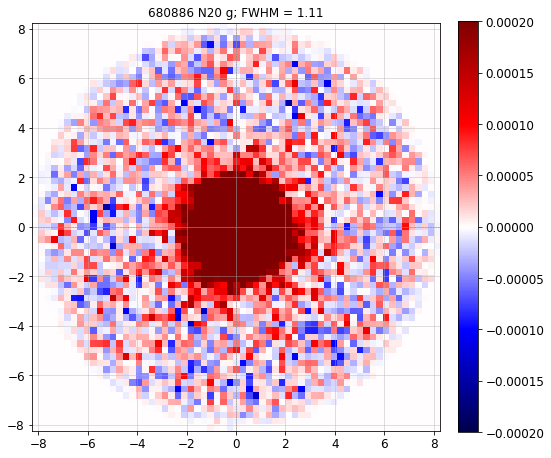

692086 N23 g; FWHM = 0.91


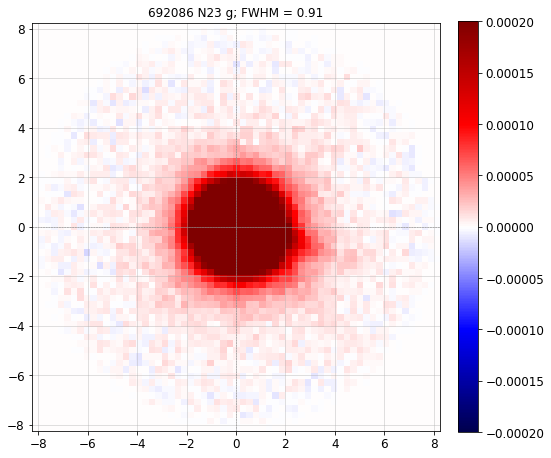

------------------------------------------------------------
696601 N5 g; FWHM = 1.19


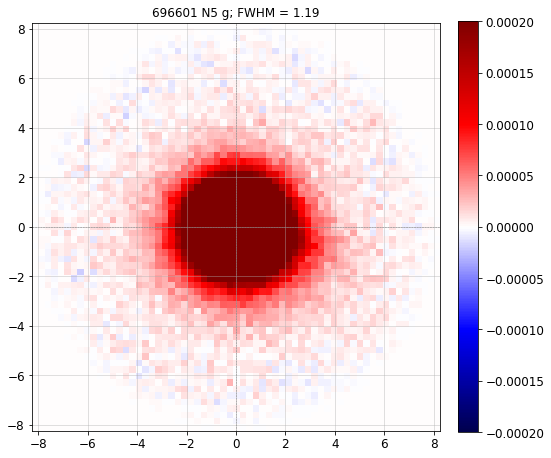

In [21]:
vrange = 0.0002
for index, ccd_index in enumerate(idx):
    
    if (index!=0) and (ccd['expnum'][ccd_index]!=ccd['expnum'][idx[index-1]]):
        print('------------------------------------------------------------')

    expnum = ccd['expnum'][ccd_index]
    ccdname = ccd['ccdname'][ccd_index]
    
    print('{} {} {}; FWHM = {:.2f}'.format(expnum, ccdname, ccd['filter'][ccd_index], pixscale_native*ccd['fwhm'][ccd_index]))

    expnum_str = str(expnum)

    fn = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/calib/decam/psfex-merged/{}/decam-{}.fits'.format((5-len(expnum_str[:3]))*'0'+expnum_str[:3], (8-len(expnum_str))*'0'+expnum_str)
    
    hdu = fits.open(fn)
    data = hdu[1].data
    # print(data['psf_mask'].shape)

    which_ccd = np.where(data['ccdname']==ccdname)[0][0]
    psf = data['psf_mask'][which_ccd]
    # print(psf.shape)

    psf0 = psf[0]
    # normalize to a 22.5 magnitude star
    # print(np.sum(psf0))
    psf0 = psf0/np.sum(psf0)

    grid = pixscale_native * np.linspace(-0.5*(psf0.shape[0]-1), 0.5*(psf0.shape[0]-1), psf0.shape[0])
    xx, yy = np.meshgrid(grid, grid)
    radius_grid = np.sqrt(xx**2 + yy**2)
    radius = radius_grid.flatten()

    plot_cutout(psf0, pixscale_native, vmin=-vrange, vmax=vrange)
    plt.title('{} {} {}; FWHM = {:.2f}'.format(expnum, ccdname, ccd['filter'][ccd_index], pixscale_native*ccd['fwhm'][ccd_index]))
    plt.show()

__Make more plots__

In [22]:
ccd_mask = ccd['filter']==band
print(np.sum(ccd_mask))

idx = np.where(ccd_mask)[0]
nplot = 200
if len(idx)>nplot:
    np.random.seed(1)
    idx = np.random.choice(idx, size=nplot, replace=False)
    
idx = idx[np.argsort(ccd['expnum'][idx])]

44512


In [30]:
vrange = 0.0002

for index, ccd_index in enumerate(idx):

    if (index!=0) and (ccd['expnum'][ccd_index]!=ccd['expnum'][idx[index-1]]):
        print('------------------------------------------------------------')
    
    expnum = ccd['expnum'][ccd_index]
    ccdname = ccd['ccdname'][ccd_index]
    
    print('{} {} {}; FWHM = {:.2f}'.format(expnum, ccdname, band, pixscale_native*ccd['fwhm'][ccd_index]))

    expnum_str = str(expnum)

    fn = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/calib/decam/psfex-merged/{}/decam-{}.fits'.format((5-len(expnum_str[:3]))*'0'+expnum_str[:3], (8-len(expnum_str))*'0'+expnum_str)
    
    hdu = fits.open(fn)
    data = hdu[1].data
    # print(data['psf_mask'].shape)

    which_ccd = np.where(data['ccdname']==ccdname)[0][0]
    psf = data['psf_mask'][which_ccd]
    # print(psf.shape)

    psf0 = psf[0]
    # normalize to a 22.5 magnitude star
    # print(np.sum(psf0))
    psf0 = psf0/np.sum(psf0)

    grid = pixscale_native * np.linspace(-0.5*(psf0.shape[0]-1), 0.5*(psf0.shape[0]-1), psf0.shape[0])
    xx, yy = np.meshgrid(grid, grid)
    radius_grid = np.sqrt(xx**2 + yy**2)
    radius = radius_grid.flatten()

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        img_fit = 10**(profile_fit(np.log10(radius_grid)))
        img_fit[~np.isfinite(img_fit)] = 0

    x = np.logspace(-1, 10, 1000)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.figure(figsize=(8, 6))
        plt.loglog(radius, (psf0).flatten(), '.', ms=1.)
        plt.loglog(x, 10**(profile_fit(np.log10(x))), '-', ms=1.)
        plt.axis([0.2, 10, 3e-6, 0.05])
        plt.grid(alpha=0.5)
        plt.title('{} {} {}; FWHM = {:.2f}'.format(expnum, ccdname, band, pixscale_native*ccd['fwhm'][ccd_index]))
        plt.savefig('../plots/psfex_dr9/decam_{}/profile/{}_{}_{}_psf0_profile.png'.format(band, expnum, ccdname, band))
        plt.close()

    plot_cutout(psf0, pixscale_native, vmin=-vrange, vmax=vrange)
    plt.title('{} {} {}; FWHM = {:.2f}'.format(expnum, ccdname, band, pixscale_native*ccd['fwhm'][ccd_index]))
    plt.savefig('../plots/psfex_dr9/decam_{}/image/{}_{}_{}_psf0_img.png'.format(band, expnum, ccdname, band))
    plt.close()

229692 N15 g; FWHM = 1.52
------------------------------------------------------------
229702 N17 g; FWHM = 1.23
------------------------------------------------------------
231956 S31 g; FWHM = 1.57
------------------------------------------------------------
231962 N15 g; FWHM = 1.30
------------------------------------------------------------
231963 S8 g; FWHM = 1.42
------------------------------------------------------------
232409 N31 g; FWHM = 1.08
------------------------------------------------------------
232419 N6 g; FWHM = 1.19
------------------------------------------------------------
232429 N14 g; FWHM = 1.26
------------------------------------------------------------
232842 S1 g; FWHM = 1.40
------------------------------------------------------------
232843 N25 g; FWHM = 1.61
------------------------------------------------------------
232849 N2 g; FWHM = 1.44
------------------------------------------------------------
233205 S1 g; FWHM = 1.44
233205 S10 g; FWHM = 1

------------------------------------------------------------
577380 N1 g; FWHM = 1.24
------------------------------------------------------------
579474 S24 g; FWHM = 1.29
------------------------------------------------------------
579884 N13 g; FWHM = 1.22
------------------------------------------------------------
585245 N3 g; FWHM = 1.47
------------------------------------------------------------
585249 S10 g; FWHM = 1.31
------------------------------------------------------------
585251 S11 g; FWHM = 1.17
------------------------------------------------------------
585255 N15 g; FWHM = 1.39
585255 N3 g; FWHM = 1.36
------------------------------------------------------------
586658 N23 g; FWHM = 1.27
------------------------------------------------------------
587077 S4 g; FWHM = 1.06
------------------------------------------------------------
587444 S1 g; FWHM = 1.27
------------------------------------------------------------
587446 N23 g; FWHM = 1.11
587446 N1 g; FWHM = 1.

---------
## Fraction of flux within a specific radius

In [43]:
radius_cut = 4. # arcsec


vrange = 0.0002

for index, ccd_index in enumerate(idx):

    # if (index!=0) and (ccd['expnum'][ccd_index]!=ccd['expnum'][idx[index-1]]):
    #     print('------------------------------------------------------------')
    
    expnum = ccd['expnum'][ccd_index]
    ccdname = ccd['ccdname'][ccd_index]
    
    print('{} {} {}; FWHM = {:.2f}'.format(expnum, ccdname, band, pixscale_native*ccd['fwhm'][ccd_index]))

    expnum_str = str(expnum)

    fn = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/calib/decam/psfex-merged/{}/decam-{}.fits'.format((5-len(expnum_str[:3]))*'0'+expnum_str[:3], (8-len(expnum_str))*'0'+expnum_str)
    
    hdu = fits.open(fn)
    data = hdu[1].data
    # print(data['psf_mask'].shape)

    which_ccd = np.where(data['ccdname']==ccdname)[0][0]
    psf = data['psf_mask'][which_ccd]
    # print(psf.shape)

    psf0 = psf[0]
    # normalize to a 22.5 magnitude star
    # print(np.sum(psf0))
    psf0 = psf0/np.sum(psf0)
    
    grid = pixscale_native * np.linspace(-0.5*(psf0.shape[0]-1), 0.5*(psf0.shape[0]-1), psf0.shape[0])
    xx, yy = np.meshgrid(grid, grid)
    radius_grid = np.sqrt(xx**2 + yy**2)
    radius = radius_grid.flatten()
    
    mask_img = radius_grid<radius_cut
    psf0_m = psf0.copy()
    psf0_m[~mask_img] = np.nan
    print(np.sum(psf0[~mask_img])/np.sum(psf0))

    # with warnings.catch_warnings():
    #     warnings.simplefilter("ignore")
    #     img_fit = 10**(profile_fit(np.log10(radius_grid)))
    #     img_fit[~np.isfinite(img_fit)] = 0

    # x = np.logspace(-1, 10, 1000)
    # with warnings.catch_warnings():
    #     warnings.simplefilter("ignore")
    #     plt.figure(figsize=(8, 6))
    #     plt.loglog(radius, (psf0_m).flatten(), '.', ms=1.)
    #     plt.loglog(x, 10**(profile_fit(np.log10(x))), '-', ms=1.)
    #     plt.axis([0.2, 10, 3e-6, 0.05])
    #     plt.grid(alpha=0.5)
    #     plt.title('{} {} {}; FWHM = {:.2f}'.format(expnum, ccdname, band, pixscale_native*ccd['fwhm'][ccd_index]))
    #     plt.show()

    # plot_cutout(psf0_m, pixscale_native, vmin=-vrange, vmax=vrange)
    # plt.title('{} {} {}; FWHM = {:.2f}'.format(expnum, ccdname, band, pixscale_native*ccd['fwhm'][ccd_index]))
    # plt.show()

229702 N17 g; FWHM = 1.23
0.00726823
238939 N17 g; FWHM = 1.40
0.0165235
240572 N14 g; FWHM = 1.22
0.011339
241184 N28 g; FWHM = 1.20
0.0157458
247189 N10 g; FWHM = 1.66
0.0152644
257236 S14 g; FWHM = 1.24
0.00867162
268794 S17 g; FWHM = 1.02
0.00649822
511513 S21 g; FWHM = 1.17
0.0139395
579474 S24 g; FWHM = 1.29
0.00968306
585245 N3 g; FWHM = 1.47
0.0168151
586658 N23 g; FWHM = 1.27
0.0214387
593758 S5 g; FWHM = 1.12
0.0158954
596118 S4 g; FWHM = 1.12
0.00578175
659873 N28 g; FWHM = 1.33
0.012246
670256 N22 g; FWHM = 1.08
0.0103218
672421 S23 g; FWHM = 1.07
0.00891817
672815 S4 g; FWHM = 1.26
0.0088572
680886 N20 g; FWHM = 1.11
0.0103165
692086 N23 g; FWHM = 0.91
0.00735532
696601 N5 g; FWHM = 1.19
0.0125754
